In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm


In [4]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [5]:
import sys
sys.path.append('..')

In [6]:
from model.laplacian import Laplacian
from model.features import Features
from model.targets import Targets
from model.regression.basic import LinearRegression, LassoRegression, RidgeRegression
from model.regression.glskgr import GLSKGR
from model.regression.kgr import KGR


../model/regression/basic.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [7]:
laplacian = Laplacian()

In [8]:
features = Features()

In [9]:
targets = Targets('Ozone')

In [10]:
model_kgr = KGR(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50)

In [11]:
model_kgr.set_laplacian(laplacian).set_data(features, targets).optimize()

({'gamma': 0.003727593720314938,
  'K_std': 91.02981779915217,
  'filter_func': 'sigmoid',
  'beta': 62.505519252739695},
 0.644421206675043)

<IPython.core.display.Javascript object>


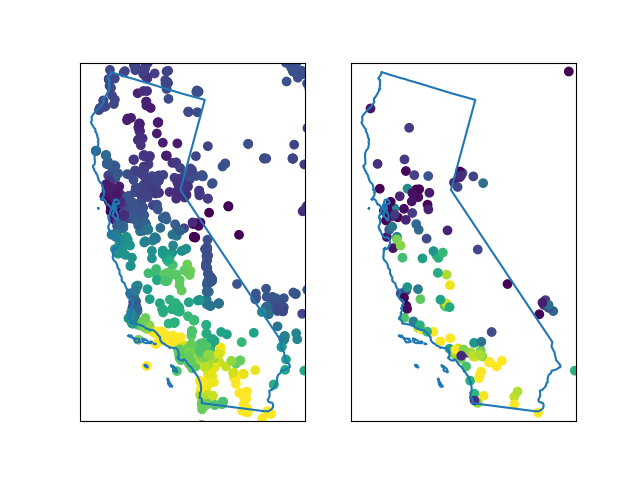

In [18]:
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True)

ti = 120
t = model.targets.Y.columns[ti]

laplacian.distance.cali.plot_outline(axes[0], dict(color='tab:blue'))
laplacian.distance.cali.plot_outline(axes[1], dict(color='tab:blue'))

vmin = np.quantile(model.targets.Y.loc[:, t], 0.1)
vmax = np.quantile(model.targets.Y.loc[:, t], 0.9)

axes[0].scatter(model.targets.sites['x'], model.targets.sites['y'], c=model.F.loc[:, t], alpha=1, vmin=vmin, vmax=vmax)

axes[1].scatter(model.targets.sites.loc[model.targets.train_sites, 'x'], model.targets.sites.loc[model.targets.train_sites, 'y'], c=model.targets.Y.loc[:, t], alpha=1, vmin=vmin, vmax=vmax)


In [12]:
model_linr = LinearRegression(fit_intercept=True)
model_linr.set_data(features, targets).optimize()

({'fit_intercept': False}, 1.1276376116519338)

In [14]:
model_ridr = RidgeRegression(fit_intercept=True, alpha=50)
model_ridr.set_data(features, targets).optimize()

({'fit_intercept': True, 'alpha': 1206.792640639329}, 0.7298939607869788)

In [15]:
model_lasr = LassoRegression(fit_intercept=True, alpha=1)
model_lasr.set_data(features, targets).optimize()

({'fit_intercept': True, 'alpha': 0.02442053094548651}, 0.7283141901929902)

In [19]:
model_glskgr = GLSKGR(**{'gamma': 0.003727593720314938, 'K_std': 91.02981779915217, 'filter_func': 'sigmoid', 'beta': 62.505519252739695})
model_glskgr.set_laplacian(laplacian).set_data(features, targets).solve_GLS()

In [32]:
def get_results():
    
    models = {'KGR': KGR, 
              'LinearRegression': LinearRegression, 
              'RidgeRegression': RidgeRegression, 
              'LassoRegression': LassoRegression, 
              'GLSKGR': GLSKGR}
    
    init_params = {'KGR': dict(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50), 
                   'LinearRegression': dict(fit_intercept=True), 
                   'RidgeRegression': dict(fit_intercept=True, alpha=50),
                   'LassoRegression': dict(fit_intercept=True, alpha=1)}#
    
    metrics = ['Ozone', 'SO2', 'CO', 'NO2', 'PM25', 'PM10']
    models = ['KGR', 'LinearRegression', 'RidgeRegression', 'LassoRegression', 'GLSKGR']
    
    opt_params = {metric: {model: {} for model in models} for metric in metrics}
    RMSE = {metric: {model: {} for model in models} for metric in metrics}
    
    laplacian = Laplacian()
    features = Features()
    
    metrics_bar = tqdm(metrics)
    
    for metric in metrics_bar:
        metrics_bar.set_description(metric)
        targets = Targets('metric')
        
        models_bar = tqdm(models)
        
        for model in models_bar:
            
            models_bar.set_description(model)
            
            if model != GLSKGR:
                reg = models[model](**init_params(model))
                
                if model != 'KGR':
                    opt_params[metric][model] = reg.set_data(features, targets).optimize()[0]
                    
                else:
                    opt_params[metric][model] = reg.set_laplacian(laplacian).set_data(features, targets).optimize()[0]
                    
            else:
                reg = models[model](**opt_params[metric]['KGR'])
                opt_params[metric][model] = opt_params[metric]['KGR']
                reg.solve_GLS()
            
            RMSE[metric][model]['Missing Nodes'] = reg.RMSE_missing_nodes()
            RMSE[metric][model]['Labelled'] = reg.RMSE_labelled()
            RMSE[metric][model]['Missing Dates'] = reg.RMSE_missing_times()
            RMSE[metric][model]['All Unlabelled'] = reg.RMSE_unlabelled_full()
            
    return opt_params, RMSE
            

In [13]:
models = {'KGR': KGR, 
          'LinearRegression': LinearRegression, 
          'RidgeRegression': RidgeRegression, 
          'LassoRegression': LassoRegression, 
          'GLSKGR': GLSKGR}

init_params = {'KGR': dict(gamma=0.01, K_std=50, filter_func='sigmoid', beta=50), 
               'LinearRegression': dict(fit_intercept=True), 
               'RidgeRegression': dict(fit_intercept=True, alpha=50),
               'LassoRegression': dict(fit_intercept=True, alpha=1)}#

metrics = ['Ozone', 'SO2', 'CO', 'NO2', 'PM25', 'PM10']
model_names = ['KGR', 'LinearRegression', 'RidgeRegression', 'LassoRegression', 'GLSKGR']

opt_params = {metric: {model: {} for model in model_names} for metric in metrics}
RMSE = {metric: {model: {} for model in model_names} for metric in metrics}

In [8]:
laplacian = Laplacian()
features = Features()

In [ ]:
metrics_bar = tqdm(metrics)

for metric in metrics_bar:
    metrics_bar.set_description(metric)
    targets = Targets(metric)
    
    models_bar = tqdm(models)

    for model in models_bar:

        models_bar.set_description(model)

        if model != GLSKGR:
            reg = models[model](**init_params[model])

            if model != 'KGR':
                opt_params[metric][model] = reg.set_data(features, targets).optimize()[0]

            else:
                opt_params[metric][model] = reg.set_laplacian(laplacian).set_data(features, targets).optimize()[0]

        else:
            reg = models[model](**opt_params[metric]['KGR'])
            opt_params[metric][model] = opt_params[metric]['KGR']
            reg.solve_GLS()

        RMSE[metric][model]['Missing Nodes'] = reg.RMSE_missing_nodes()
        RMSE[metric][model]['Labelled'] = reg.RMSE_labelled()
        RMSE[metric][model]['Missing Dates'] = reg.RMSE_missing_times()
        RMSE[metric][model]['All Unlabelled'] = reg.RMSE_unlabelled_full()